In [1]:
import pandas as pd
import numpy as np
import time
import random
import forms
import matplotlib.pyplot as plt

from typing import Callable
from forms.executor.dfexecutor.lookup.lookupfuncexecutor import (
    lookup_binary_search,
    lookup_binary_search_np,
    lookup_sort_merge,
)
from forms.executor.dfexecutor.lookup.vlookupfuncexecutor import vlookup_exact_hash, vlookup_exact_loops

# Benchmark Utils

In [2]:
def create_df(size=(1000, 10), df_type="constant", start_val: float = 0, first_col_idx=True, seed=2):
    rows, cols = size
    assert rows >= 1 and cols >= 1
    lst = [([0.0] * cols) for _ in range(rows)]
    random.seed(seed)
    for i in range(rows):
        col_start = 0
        if first_col_idx:
            col_start = 1
            lst[i][0] = i
        for j in range(col_start, cols):
            if df_type == "constant":
                val = start_val
            elif df_type == "range":
                val = start_val + i
            elif df_type == "random":
                val = random.random() * rows
            else:
                raise IOError(f"Df type {df_type} is not supported!")
            lst[i][j] = val
    return pd.DataFrame(lst)

# Lookup Algorithms

## Trial Functions

In [3]:
def run_lookup_trials(df: pd.DataFrame, lookup_func: Callable):
    values, search_range, result_range = df.iloc[:, 1], df.iloc[:, 0], df.iloc[:, 2]

    iterations: int = 3

    # Warm up cache
    lookup_func(values, search_range, result_range)

    # Run trials
    total_time = 0
    for i in range(iterations):
        start_time = time.time()
        lookup_func(values, search_range, result_range)
        total_time += time.time() - start_time

    return total_time / iterations

In [4]:
def run_vlookup_exact_trials(df: pd.DataFrame, lookup_func: Callable):
    values = df.iloc[:, 1]
    col_idxes = pd.Series([df.shape[1]] * df.shape[0])

    iterations: int = 3

    # Warm up cache
    lookup_func(values, df, col_idxes)

    # Run trials
    total_time = 0
    for i in range(iterations):
        start_time = time.time()
        lookup_func(values, df, col_idxes)
        total_time += time.time() - start_time

    return total_time / iterations

## Benchmark Approximate LOOKUP

Cases:
- Values are constant
- Values range from 0 to len - 1
- Values range from 0.5 to len - 0.5
- Values range from -2.5 to len - 3.5
- Values are random

In [5]:
print("\nBENCHMARKING LOOKUP", "-" * 40, "\n")

subtitle1, subtitle2, subtitle3 = "Binary search", "Sort merge", "Binary search NumPy"


def run_lookup_benchmark(df, title):
    # time1 = run_lookup_trials(df, lookup_binary_search)
    time2 = run_lookup_trials(df, lookup_sort_merge)
    time3 = run_lookup_trials(df, lookup_binary_search_np)
    print(title)
    # print(f"{subtitle1} time: {time1}")
    print(f"{subtitle2} time: {time2}")
    print(f"{subtitle3} time: {time3}")
    print()
    return time2, time3


sizes = [100, 500, 1000, 5000, 10000]
sm_times, bs_times = [], []

for i in sizes:

    print("DataFrame size:", i, "records", "-" * 20, "\n")
    sm_total_time, bs_total_time = 0, 0

    df = create_df(size=(i, 10), df_type="constant", start_val=50)
    sm_time, bs_time = run_lookup_benchmark(df, "Constant DataFrame Exact")
    sm_total_time, bs_total_time = sm_total_time + sm_time, bs_total_time + bs_time

    df = create_df(size=(i, 10), df_type="range", start_val=0)
    sm_time, bs_time = run_lookup_benchmark(df, "Range DataFrame Exact")
    sm_total_time, bs_total_time = sm_total_time + sm_time, bs_total_time + bs_time

    df = create_df(size=(i, 10), df_type="range", start_val=0.5)
    sm_time, bs_time = run_lookup_benchmark(df, "Range DataFrame Approximate")
    sm_total_time, bs_total_time = sm_total_time + sm_time, bs_total_time + bs_time

    df = create_df(size=(i, 10), df_type="range", start_val=-2.5)
    sm_time, bs_time = run_lookup_benchmark(df, "Range DataFrame Approximate NaN")
    sm_total_time, bs_total_time = sm_total_time + sm_time, bs_total_time + bs_time

    df = create_df(size=(i, 10), df_type="random")
    sm_time, bs_time = run_lookup_benchmark(df, "Random DataFrame Approximate")
    sm_total_time, bs_total_time = sm_total_time + sm_time, bs_total_time + bs_time

    sm_times.append(sm_total_time / 5)
    bs_times.append(bs_total_time / 5)


BENCHMARKING LOOKUP ---------------------------------------- 

DataFrame size: 100 records -------------------- 

Constant DataFrame Exact
Sort merge time: 0.0008134047190348307
Binary search NumPy time: 0.001141945521036784

Range DataFrame Exact
Sort merge time: 0.0016856193542480469
Binary search NumPy time: 0.0011037190755208333

Range DataFrame Approximate
Sort merge time: 0.0025206406911214194
Binary search NumPy time: 0.0009731451670328776

Range DataFrame Approximate NaN
Sort merge time: 0.002433300018310547
Binary search NumPy time: 0.0009905497233072917

Random DataFrame Approximate
Sort merge time: 0.0019179979960123699
Binary search NumPy time: 0.001081228256225586

DataFrame size: 500 records -------------------- 

Constant DataFrame Exact
Sort merge time: 0.0027322769165039062
Binary search NumPy time: 0.005003054936726888

Range DataFrame Exact
Sort merge time: 0.007670243581136067
Binary search NumPy time: 0.0073286692301432295

Range DataFrame Approximate
Sort merge t

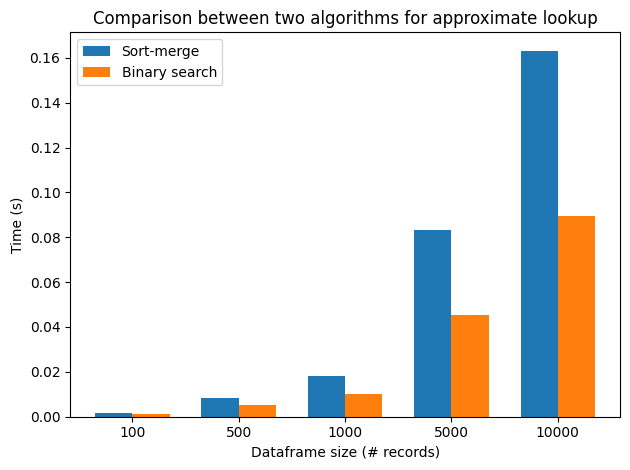

In [6]:
x = np.arange(len(sizes))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width / 2, sm_times, width, label="Sort-merge")
ax.bar(x + width / 2, bs_times, width, label="Binary search")

ax.set_xlabel("Dataframe size (# records)")
ax.set_ylabel("Time (s)")
ax.set_title("Comparison between two algorithms for approximate lookup")
ax.set_xticks(x, sizes)
ax.legend()

fig.tight_layout()
plt.savefig(f"plots/approx-lookup.png")

## Benchmark Exact VLOOKUP

Cases:
- Values are constant
- Values range from 0 to len - 1
- Values range from 0.5 to len - 0.5 (should product all NaN values)

In [7]:
print("\nBENCHMARKING VLOOKUP EXACT", "-" * 33, "\n")

subtitle1, subtitle2, subtitle3 = "Nested Loops", "Hash and Probe", "Binary search NumPy"


def run_vlookup_benchmark(df, title):
    time1 = run_vlookup_exact_trials(df, vlookup_exact_loops)
    time2 = run_vlookup_exact_trials(df, vlookup_exact_hash)
    print(title)
    print(f"{subtitle1} time: {time1}")
    print(f"{subtitle2} time: {time2}")
    print()
    return time1, time2


sizes = [100, 500, 1000, 5000, 10000]
loops_times, hash_times = [], []

for i in sizes:

    print("DataFrame size:", i, "records", "-" * 20, "\n")
    loops_total_time, hash_total_time = 0, 0

    df = create_df(size=(i, 10), df_type="constant", start_val=50)
    loops_time, hash_time = run_vlookup_benchmark(df, "Constant DataFrame Exact")
    loops_total_time, hash_total_time = loops_total_time + loops_time, hash_total_time + hash_time

    df = create_df(size=(i, 10), df_type="range", start_val=0)
    loops_time, hash_time = run_vlookup_benchmark(df, "Range DataFrame Exact")
    loops_total_time, hash_total_time = loops_total_time + loops_time, hash_total_time + hash_time

    df = create_df(size=(i, 10), df_type="range", start_val=0.5)
    loops_time, hash_time = run_vlookup_benchmark(df, "Range DataFrame All NaN")
    loops_total_time, hash_total_time = loops_total_time + loops_time, hash_total_time + hash_time

    loops_times.append(loops_total_time / 3)
    hash_times.append(hash_total_time / 3)


BENCHMARKING VLOOKUP EXACT --------------------------------- 

DataFrame size: 100 records -------------------- 

Constant DataFrame Exact
Nested Loops time: 0.01008764902750651
Hash and Probe time: 0.004936615626017253

Range DataFrame Exact
Nested Loops time: 0.010475238164265951
Hash and Probe time: 0.004295746485392253

Range DataFrame All NaN
Nested Loops time: 0.005791107813517253
Hash and Probe time: 0.0022736390431722007

DataFrame size: 500 records -------------------- 

Constant DataFrame Exact
Nested Loops time: 0.05948122342427572
Hash and Probe time: 0.023897409439086914

Range DataFrame Exact
Nested Loops time: 0.05799349149068197
Hash and Probe time: 0.025027354558308918

Range DataFrame All NaN
Nested Loops time: 0.055329322814941406
Hash and Probe time: 0.011166652043660482

DataFrame size: 1000 records -------------------- 

Constant DataFrame Exact
Nested Loops time: 0.14599029223124185
Hash and Probe time: 0.04331398010253906

Range DataFrame Exact
Nested Loops tim

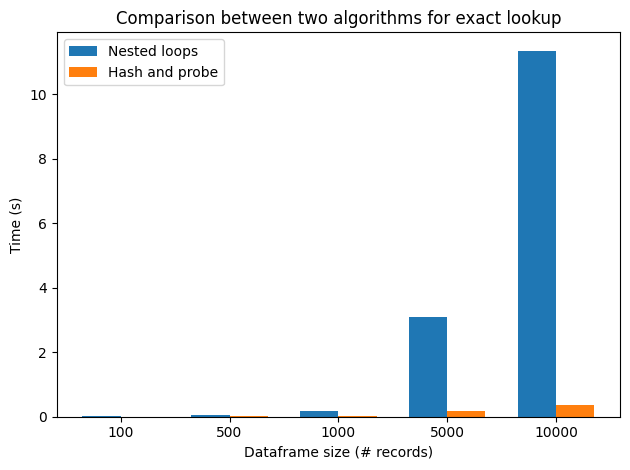

In [8]:
x = np.arange(len(sizes))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width / 2, loops_times, width, label="Nested loops")
ax.bar(x + width / 2, hash_times, width, label="Hash and probe")

ax.set_xlabel("Dataframe size (# records)")
ax.set_ylabel("Time (s)")
ax.set_title("Comparison between two algorithms for exact lookup")
ax.set_xticks(x, sizes)
ax.legend()

fig.tight_layout()
plt.savefig(f"plots/exact-lookup.png")

# End-to-End Scaling

End to end testing running `LOOKUP(A1, C1:C1000, G1:G1000)`

Cases:
- Values are constant
- Values range from 0 to len - 1
- Values range from 0.5 to len - 0.5 (should product all NaN values)

DataFrame size: 100 records ------------------------------ 

Num cores: 1 ------------------------------ 

Constant DataFrame Exact ---------- 



2022-11-18 17:55:10,677 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/t5/_4flt3r11tndj_cr86qj2jyc0000gn/T/dask-worker-space/worker-eh0gs_89', purging


Distributing data time: 0.007327079772949219
Execution time: 0.7289669513702393
Get table content time: 0.002991914749145508
Distributing data time: 0.0034461021423339844
Execution time: 0.04375290870666504
Get table content time: 0.0029850006103515625
Distributing data time: 0.0051729679107666016
Execution time: 0.034631967544555664
Get table content time: 0.0044820308685302734
Total time: 0.6713802814483643

Range DataFrame Exact ---------- 

Distributing data time: 0.003545045852661133
Execution time: 0.045706987380981445
Get table content time: 0.0031349658966064453
Distributing data time: 0.003603219985961914
Execution time: 0.04610419273376465
Get table content time: 0.0029451847076416016
Distributing data time: 0.0029921531677246094
Execution time: 0.03517603874206543
Get table content time: 0.0037240982055664062
Total time: 0.04963556925455729

Range DataFrame All NaN ---------- 

Distributing data time: 0.005099058151245117
Execution time: 0.046766042709350586
Get table conten

Execution time: 0.05787491798400879
Get table content time: 0.015227794647216797
Distributing data time: 0.004612922668457031
Execution time: 0.0563812255859375
Get table content time: 0.013517141342163086
Distributing data time: 0.003964900970458984
Execution time: 0.057389020919799805
Get table content time: 0.013689279556274414
Total time: 0.07654237747192383

Range DataFrame Exact ---------- 

Distributing data time: 0.0037157535552978516
Execution time: 0.054141998291015625
Get table content time: 0.01621699333190918
Distributing data time: 0.004289150238037109
Execution time: 0.05698585510253906
Get table content time: 0.014225959777832031
Distributing data time: 0.0040130615234375
Execution time: 0.09180068969726562
Get table content time: 0.009576082229614258
Total time: 0.0858919620513916

Range DataFrame All NaN ---------- 

Distributing data time: 0.003838062286376953
Execution time: 0.04544782638549805
Get table content time: 0.009824037551879883
Distributing data time: 0.0

Execution time: 0.04514503479003906
Get table content time: 0.003161191940307617
Distributing data time: 0.004647970199584961
Execution time: 0.04767584800720215
Get table content time: 0.004331827163696289
Total time: 0.05468908945719401

Range DataFrame All NaN ---------- 

Distributing data time: 0.004531145095825195
Execution time: 0.041863203048706055
Get table content time: 0.0036139488220214844
Distributing data time: 0.004461050033569336
Execution time: 0.046095848083496094
Get table content time: 0.0032320022583007812
Distributing data time: 0.005136728286743164
Execution time: 0.04579925537109375
Get table content time: 0.0030820369720458984
Total time: 0.0534365177154541

Num cores: 2 ------------------------------ 

Constant DataFrame Exact ---------- 

Distributing data time: 0.003881216049194336
Execution time: 0.04346013069152832
Get table content time: 0.0058591365814208984
Distributing data time: 0.003962993621826172
Execution time: 0.0553891658782959
Get table content

Execution time: 0.0884709358215332
Get table content time: 0.008116006851196289
Total time: 0.11619655291239421

Range DataFrame Exact ---------- 

Distributing data time: 0.004232168197631836
Execution time: 0.09968304634094238
Get table content time: 0.012808799743652344
Distributing data time: 0.004395008087158203
Execution time: 0.10503387451171875
Get table content time: 0.01437687873840332
Distributing data time: 0.0047681331634521484
Execution time: 0.09213709831237793
Get table content time: 0.012918949127197266
Total time: 0.11742726961771648

Range DataFrame All NaN ---------- 

Distributing data time: 0.004702329635620117
Execution time: 0.09190201759338379
Get table content time: 0.012126922607421875
Distributing data time: 0.00627899169921875
Execution time: 0.11005592346191406
Get table content time: 0.013319015502929688
Distributing data time: 0.005483865737915039
Execution time: 0.09478974342346191
Get table content time: 0.014793872833251953
Total time: 0.1187556584676

Range DataFrame Exact ---------- 

Distributing data time: 0.0043489933013916016
Execution time: 0.15085911750793457
Get table content time: 0.015604019165039062
Distributing data time: 0.006516933441162109
Execution time: 0.14023804664611816
Get table content time: 0.01651787757873535
Distributing data time: 0.004907846450805664
Execution time: 0.1395738124847412
Get table content time: 0.016313791275024414
Total time: 0.16566809018452963

Range DataFrame All NaN ---------- 

Distributing data time: 0.005135297775268555
Execution time: 0.13701868057250977
Get table content time: 0.015552997589111328
Distributing data time: 0.004787921905517578
Execution time: 0.1401369571685791
Get table content time: 0.01823711395263672
Distributing data time: 0.005502939224243164
Execution time: 0.12964105606079102
Get table content time: 0.017750978469848633
Total time: 0.1589223543802897

DataFrame size: 50000 records ------------------------------ 

Num cores: 1 ------------------------------ 

C

Execution time: 0.8823940753936768
Get table content time: 0.009693145751953125
Distributing data time: 0.022278785705566406
Execution time: 0.8237743377685547
Get table content time: 0.008780956268310547
Distributing data time: 0.019496917724609375
Execution time: 0.7332758903503418
Get table content time: 0.007080793380737305
Total time: 0.8462168375651041

Num cores: 2 ------------------------------ 

Constant DataFrame Exact ---------- 

Distributing data time: 0.01573491096496582
Execution time: 0.9573330879211426
Get table content time: 0.008867979049682617
Distributing data time: 0.021355867385864258
Execution time: 0.8792948722839355
Get table content time: 0.01299595832824707
Distributing data time: 0.019262075424194336
Execution time: 0.8818280696868896
Get table content time: 0.011129140853881836
Total time: 0.9369432131449381

Range DataFrame Exact ---------- 

Distributing data time: 0.015950918197631836
Execution time: 0.9040989875793457
Get table content time: 0.01368331

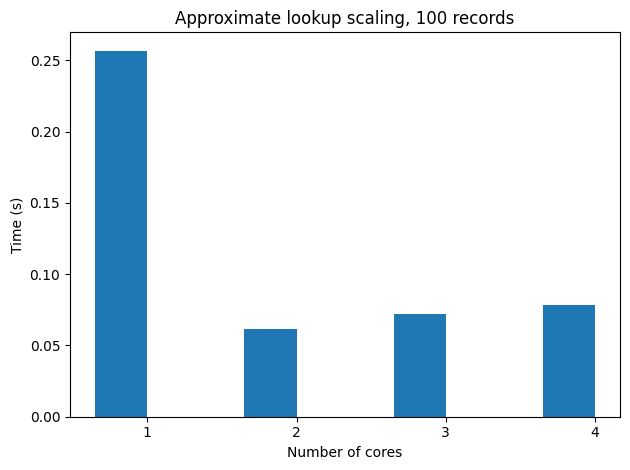

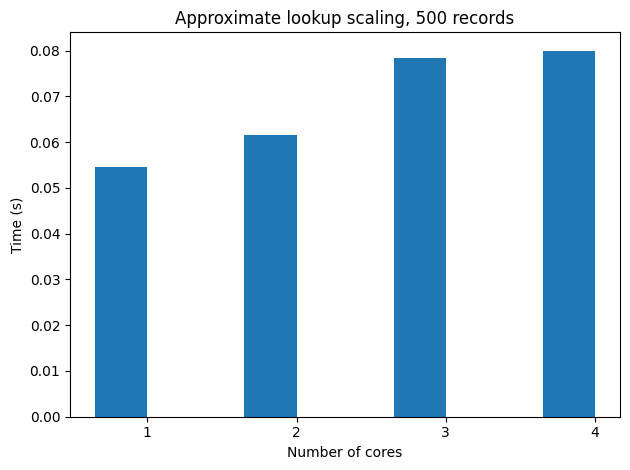

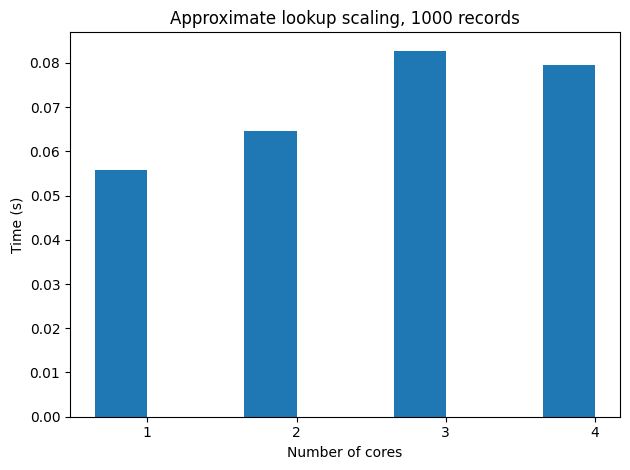

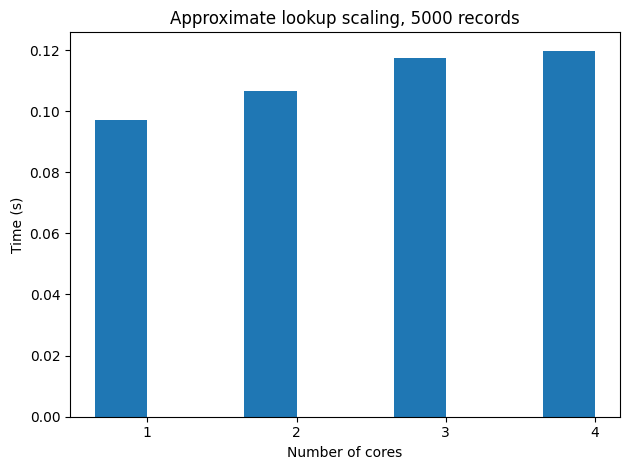

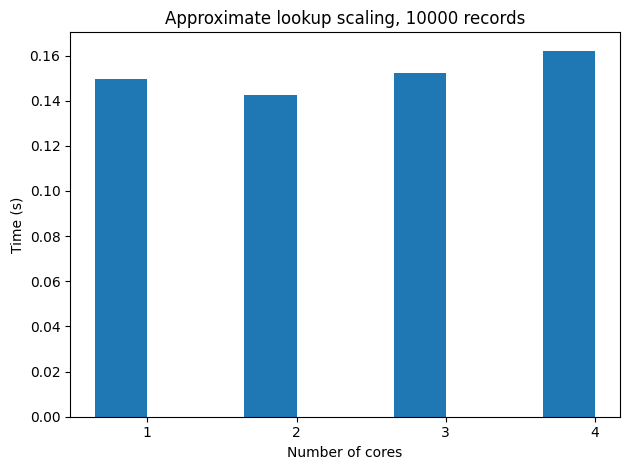

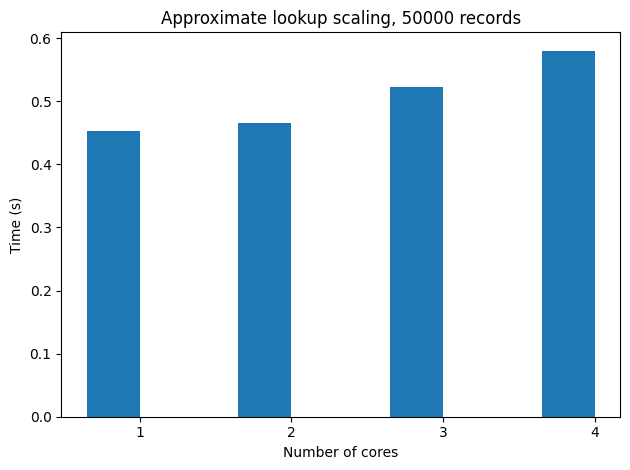

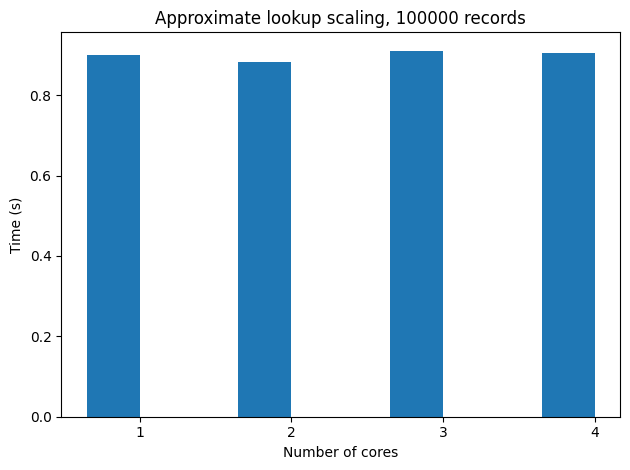

In [9]:
def run_lookup_e2e(df, title):
    iterations = 3
    total_time = 0
    print(f"{title}", "-" * 10, "\n")
    for _ in range(iterations):
        start = time.time()
        forms.compute_formula(df, "=LOOKUP(A1, C1:C1000, G1:G1000)")
        total_time += time.time() - start
    print(f"Total time: {total_time / iterations}")
    print()
    return total_time / iterations


sizes = [100, 500, 1000, 5000, 10000, 50000, 100000]
cores = [1, 2, 3, 4]

for i in sizes:

    print("DataFrame size:", i, "records", "-" * 30, "\n")
    times = []

    for c in cores:

        print("Num cores:", c, "-" * 30, "\n")
        total_time = 0

        forms.config(cores=c, function_executor="df_pandas_executor")

        df = create_df(size=(i, 10), df_type="constant", start_val=50)
        total_time += run_lookup_e2e(df, "Constant DataFrame Exact")

        df = create_df(size=(i, 10), df_type="range", start_val=0)
        total_time += run_lookup_e2e(df, "Range DataFrame Exact")

        df = create_df(size=(i, 10), df_type="range", start_val=0.5)
        total_time += run_lookup_e2e(df, "Range DataFrame All NaN")

        times.append(total_time / 3)

    x = np.arange(len(cores))
    width = 0.35

    fig, ax = plt.subplots()
    ax.bar(x - width / 2, times, width)

    ax.set_xlabel("Number of cores")
    ax.set_ylabel("Time (s)")
    ax.set_title(f"Approximate lookup scaling, {i} records")
    ax.set_xticks(x, cores)

    fig.tight_layout()
    plt.savefig(f"plots/scaling-{i}.png")